In [1]:
import os
import re
import os
import tqdm
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pprint import pprint
import graphviz

from collections import defaultdict
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error, r2_score


In [61]:
data_path = "data/html/*.html"

code2convos = dict()

pbar = tqdm.tqdm(sorted(list(glob(data_path))))
for path in pbar:
    # print(Path.cwd() / path)
    file_code = os.path.basename(path).split(".")[0]
    with open(path, "r", encoding="latin1") as fh:
            
        # get the file id to USE IT AS A KEY later on
        fid = os.path.basename(path).split(".")[0]

        # read the html file
        html_page = fh.read()

        # parse the html file with bs4 so we can extract needed stuff
        soup = BeautifulSoup(html_page, "html.parser")

        # grab the conversations with the data-testid pattern
        data_test_id_pattern = re.compile(r"conversation-turn-[0-9]+")
        conversations = soup.find_all("div", attrs={"data-testid": data_test_id_pattern})

        convo_texts = []

        for i, convo in enumerate(conversations):
            convo = convo.find_all("div", attrs={"data-message-author-role":re.compile( r"[user|assistant]") })
            if len(convo) > 0:
                role = convo[0].get("data-message-author-role")
                convo_texts.append({
                        "role" : role,
                        "text" : convo[0].text
                    }
                )
                
        code2convos[file_code] = convo_texts

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:12<00:00, 10.47it/s]


In [56]:
# let's see one of the conversations
pprint(code2convos["0031c86e-81f4-4eef-9e0e-28037abf9883"])

[{'role': 'user',
  'text': 'Load a CSV file into a Pandas in Python. The file is named '
          "'cs412_hw1_dataset.csv' and contains columns like 'Species', "
          "'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', "
          "'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and "
          "'Health Metrics'. \n"},
 {'code': "import pandas as pd file_path = 'cs412_hw1_dataset.csv' df = "
          'pd.read_csv(file_path) print(df.head())',
  'commentCode': '# Specify the file path # Load the CSV file into a Pandas '
                 'DataFrame # Display the first few rows of the DataFrame to '
                 'verify the data has been loaded',
  'role': 'assistant',
  'text': 'You can load a CSV file into a Pandas DataFrame in Python using the '
          "pandas.read_csv() function. Here's how you can do it for your "
          'specific CSV file\n'
          "This code assumes that the CSV file 'cs412_hw1_dataset.csv' is in "
          'the same

In [62]:
#Takes a text as an input and divides it into code,text,commentCode
#by following a similar pattern used in ChatGPT responses that include code example.

def distinguisher(response):
    index=response.find(":pythonCopy code")
    index2=response.rfind("\n")
    
    if(index!=-1):
        text_part = response[:index]+ response[index2:]

        code_part = response[index + len(":pythonCopy code"):index2].strip()
        # Split the code into statements using '\n' as the delimiter
        code_part= code_part.split('\n')

        # Group statements based on whether they start with '#'
        comment_code = [s for s in code_part if s.startswith('#') and s!=""]
        actual_code = [s for s in code_part if not s.startswith('#')and s!=""]
        
        return{"text":text_part,"code":" ".join(actual_code), "commentCode": " ".join(comment_code) }
        
    else:
        #that means the response does not include a code

        text_part = response

        code_part = ""
        
    return {"text": text_part, "code": "", "commentCode":""}
        
    

In [63]:
#Takes the dictionary formatted in the same way as the dictionary provided to us initially
#and categorizes the output of ChatGPT as text, code ,commentCode

def divideTextAndCode(code2convos):
    for key, dictionaries in code2convos.items():
        
        # Iterate over the list of dictionaries for each key
        for dictionary in dictionaries:
            # Check if the role is "assistant"
            if dictionary["role"] == "assistant":
                # Apply the distinguisher function to the "text" field
                distinguished_parts = distinguisher(dictionary["text"])
                # Update the message dictionary with the modified "text" and "code" fields
                dictionary["text"]=distinguished_parts["text"]
                dictionary["code"]=distinguished_parts["code"]
                dictionary["commentCode"]=distinguished_parts["commentCode"]
                
    

In [64]:
divideTextAndCode(code2convos)

In [65]:
code2convos["41b82427-7ae2-4c55-b8a3-310bb4abada0"]

[{'role': 'user',
  'text': 'Read the .csv file with the pandas library can you do that'},
 {'role': 'assistant',
  'text': 'Certainly! To read a CSV file using the pandas library in Python, you can use the read_csv function. Make sure you have the pandas library installed before running the code. You can install it using:bashCopy codepip install pandas\nNow, assuming you have a CSV file named "your_file.csv", here\'s an example code to read it using pandas\nThis code assumes that the CSV file is in the same directory as your Python script or Jupyter Notebook. If the file is in a different directory, you should provide the full path or a relative path from your current working directory.You can customize the read_csv function with various parameters based on your specific CSV file format. For example, you can specify the delimiter, header presence, column names, etc. Refer to the pandas documentation for more details on the available options.',
  'code': "import pandas as pd file_path 

#### Things to do:
- Prompt matching with questions
- Feature Engineering
- Question Grades preparation
- Train/Test split
- Fitting a model for predicting the scores

#### Prompt Matching
> We want to match the prompts with the questions in the Homework Let's
> do it with a simple term frequency vectorizing method. For each prompt,
> we will come with a vector that represents it. We will do the same
> thing with each of the homework questions. Then, we will calculate the
> vectors distanance to do the matching

In [80]:
#prompts -> butun promptlar tek listede
#code2prompts -> keyler html adlari , value olarak da o htmldeki promptların listesi


prompts = []
code2prompts = defaultdict(list)
for code , convos in code2convos.items():
    user_prompts = []
    for conv in convos:
        if conv["role"] == "user":
            prompts.append(conv["text"])
            user_prompts.append(conv["text"])
    code2prompts[code] = user_prompts    
    

In [84]:
code2prompts["6312a21b-c6be-44f9-ad81-46307b339fb6"]

['Give an example of how to plot a heat map of a specific results with "matplotlib"',
 'How to select a subset of features that are likely strong predictors, justifying them based on calculated correlations',
 'How to use isnull()',
 'How to do dataset comparison',
 'How to separate the dependent variable X from the independent variable y',
 'How to split training and testing sets by 80% and 20% respectively',
 'How to calculate correlations of all features in a dataset',
 'How to select a subset of features that are likely strong predictors, justifying them based on correlations',
 'How to choose the best hypermeter?',
 'How to apply hypermeter',
 'training of hypermeters',
 'How can I visualize the trained tree?']

In [87]:
mylist1= ["hello","how"]
mylist2=["my","name","Anil"]

print(mylist1+mylist2)

['hello', 'how', 'my', 'name', 'Anil']


In [68]:
questions = [
    """Initialize
*   First make a copy of the notebook given to you as a starter.
*   Make sure you choose Connect form upper right.
*   You may upload the data to the section on your left on Colab, than right click on the .csv file and get the path of the file by clicking on "Copy Path". You will be using it when loading the data.

""",
#####################
    """Load training dataset (5 pts)
    *  Read the .csv file with the pandas library
""",
#####################
"""Understanding the dataset & Preprocessing (15 pts)
Understanding the Dataset: (5 pts)
> - Find the shape of the dataset (number of samples & number of attributes). (Hint: You can use the **shape** function)
> - Display variable names (both dependent and independent).
> - Display the summary of the dataset. (Hint: You can use the **info** function)
> - Display the first 5 rows from training dataset. (Hint: You can use the **head** function)
Preprocessing: (10 pts)

> - Check if there are any missing values in the dataset. If there are, you can either drop these values or fill it with most common values in corresponding rows. **Be careful that you have enough data for training the  model.**

> - Encode categorical labels with the mappings given in the cell below. (Hint: You can use **map** function)
""",
"""Set X & y, split data (5 pts)

*   Shuffle the dataset.
*   Seperate your dependent variable X, and your independent variable y. The column health_metrics is y, the rest is X.
*   Split training and test sets as 80% and 20%, respectively.
""",
#####################
"""Features and Correlations (10 pts)

* Correlations of features with health (4 points)
Calculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.

* Feature Selection (3 points)
Select a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.

* Hypothetical Driver Features (3 points)
Propose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.

* __Note:__ You get can get help from GPT.
""",
#####################
"""Tune Hyperparameters (20 pts)
* Choose 2 hyperparameters to tune. You can use the Scikit learn decision tree documentation for the available hyperparameters *(Hyperparameters are listed under "Parameters" in the documentation)*. Use GridSearchCV for hyperparameter tuning, with a cross-validation value of 5. Use validation accuracy to pick the best hyper-parameter values. (15 pts)
-Explain the hyperparameters you chose to tune. *(What are the hyperparameters you chose? Why did you choose them?)* (5 pts)
""",
#####################
"""Re-train and plot the decision tree with the hyperparameters you have chosen (15 pts)
- Re-train model with the hyperparameters you have chosen in part 5). (10 pts)
- Plot the tree you have trained. (5 pts)
Hint: You can import the **plot_tree** function from the sklearn library.
""",
#####################
"""Test your classifier on the test set (20 pts)
- Predict the labels of testing data using the tree you have trained in step 6. (10 pts)
- Report the classification accuracy. (2 pts)
- Plot & investigate the confusion matrix. Fill the following blanks. (8 pts)
> The model most frequently mistakes class(es) _________ for class(es) _________.
Hint: You can use the confusion_matrix function from sklearn.metrics
""",
#####################
"""Find the information gain on the first split (10 pts)""",
#####################
]

In [89]:
questions[0]

'Initialize\n*   First make a copy of the notebook given to you as a starter.\n*   Make sure you choose Connect form upper right.\n*   You may upload the data to the section on your left on Colab, than right click on the .csv file and get the path of the file by clicking on "Copy Path". You will be using it when loading the data.\n\n'

In [69]:
vectorizer = TfidfVectorizer()
vectorizer = vectorizer.fit(prompts + questions)

In [70]:
questions_TF_IDF = pd.DataFrame(vectorizer.transform(questions).toarray(), columns=vectorizer.get_feature_names_out())
questions_TF_IDF.head()

,00000,000000,000196,000282,000284,000360,000469,000750,000886,000991,...,yticks,yã,yä,zaman,zdã¼m,zero,zerodivisionerror,zeroth,zip,ã¼nã¼yorum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
code2prompts_tf_idf = dict()
for code, user_prompts in code2prompts.items():
    if len(user_prompts) == 0:
        # some files have issues
        print(code+".html")
        continue
    prompts_TF_IDF = pd.DataFrame(vectorizer.transform(user_prompts).toarray(), columns=vectorizer.get_feature_names_out())
    code2prompts_tf_idf[code] = prompts_TF_IDF

139235c7-736c-4237-92f0-92e8c116832c.html
668ad17e-0240-49f7-b5a7-d22e502554c6.html
b0640e51-6879-40cb-a4f5-329f952ef99d.html
da6b70d5-29f6-491a-ad46-037c77067128.html


In [72]:
code2prompts_tf_idf["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].head()

,00000,000000,000196,000282,000284,000360,000469,000750,000886,000991,...,yticks,yã,yä,zaman,zdã¼m,zero,zerodivisionerror,zeroth,zip,ã¼nã¼yorum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [73]:
code2prompts_tf_idf["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].shape

(86, 5400)

In [74]:
code2cosine = dict()
for code, user_prompts_tf_idf in code2prompts_tf_idf.items():
    code2cosine[code] = pd.DataFrame(cosine_similarity(questions_TF_IDF,user_prompts_tf_idf))

In [75]:
questions[4]

"Features and Correlations (10 pts)\n\n* Correlations of features with health (4 points)\nCalculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.\n\n* Feature Selection (3 points)\nSelect a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.\n\n* Hypothetical Driver Features (3 points)\nPropose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.\n\n* __Note:__ You get can get help from GPT.\n"

In [76]:
code2questionmapping = dict()
for code, cosine_scores in code2cosine.items():
    code2questionmapping[code] = code2cosine[code].max(axis=1).tolist()


question_mapping_scores = pd.DataFrame(code2questionmapping).T
question_mapping_scores.reset_index(inplace=True)
question_mapping_scores.rename(columns={i: f"Q_{i}" for i in range(len(questions))}, inplace=True)
question_mapping_scores.rename(columns={"index" : "code"}, inplace=True)

question_mapping_scores

,code,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.153541,0.294879,0.522169,0.352243,0.460606,0.553876,0.167250,0.182938,0.195440
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.192013,0.795607,0.772184,0.882656,0.607114,0.987511,0.892586,0.570741,0.543866
2,041f950b-c013-409a-a642-cffff60b9d4b,0.258306,0.295923,0.624824,0.351872,0.643038,0.454314,0.540269,0.546506,0.325793
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.145965,0.117841,0.267346,0.316809,0.333889,0.309084,0.192434,0.261892,0.407106
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.344182,0.575528,0.782883,0.624833,0.724872,0.872171,0.684797,0.945305,0.511769
...,...,...,...,...,...,...,...,...,...,...
118,f24219d6-07f0-4baf-80ac-18475dc5b66f,0.187393,0.209889,0.358875,0.211246,0.149281,0.507128,1.000000,0.862585,0.739634
119,f2f18684-4a16-4c05-a2d1-c0f96d1de869,0.144760,0.139495,0.332267,0.950344,0.775698,0.828355,0.374145,0.905688,0.553341
120,f852596d-fdca-45aa-9050-d4f76ce6a53c,0.211008,0.908697,0.977725,0.924311,0.888609,0.921306,0.779558,0.767328,0.499508
121,f8ec3336-fd48-4654-ad98-62ccfb96d096,0.173215,0.967321,1.000000,0.703987,0.942662,0.907417,1.000000,1.000000,0.782938


# Feature Engineering
- Number of prompts that a uers asked
- Number of complaints that a user makes e.g "the code gives this error!"
- User prompts average number of characters

In [175]:
import re

def calculate_discomfort_count(text):
    # Discomfort indicators
    discomfort_keywords = ["no", "not really", "confused", "error","not correct"
                       "disappointed", "frustrated", "annoyed", "doesn't work", "apologize", "does not work",
                       "didn't work", "did not work", "wrong","didnt work","doesnt work","didnt understand",
                           "did not understand", "didn't understand"
                       "assertionerror", "attributeerror", "eoferror", "floatingpointerror",
                       "generatorexit", "importerror", "indexerror", "keyerror", "keyboardinterrupt",
                       "memoryerror", "nameerror", "notimplementederror", "oserror", "overflowerror",
                       "referenceerror", "runtimeerror", "stopiteration", "syntaxerror",
                       "indentationerror", "taberror", "systemerror", "systemexit", "typeerror",
                       "unboundlocalerror", "unicodeerror", "unicodeencodeerror", "unicodedecodeerror",
                       "unicodetranslateerror", "valueerror", "zerodivisionerror"]


    # Count the number of discomfort indicators in the text
    discomfort_count = sum(1 for keyword in discomfort_keywords if re.search(rf'\b{re.escape(keyword)}\b', text.lower(), flags=re.IGNORECASE))


    return discomfort_count




In [176]:
def calculate_comfort_count(text):
    # Comfort indicators
    comfort_keywords = ["good", "great", "awesome", "satisfied", "happy", "well done", "thank you", "excellent","thanks","worked",
                       "works","well"]

    # Count the number of comfort indicators in the text
    comfort_count = sum(1 for keyword in comfort_keywords if re.search(rf'\b{re.escape(keyword)}\b', text.lower(), flags=re.IGNORECASE))

    return comfort_count

In [ ]:
import gensim.downloader
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations
# Load the GloVe model
model_name = "glove-wiki-gigaword-100"
word_to_vec = gensim.downloader.load(model_name)

In [207]:
def calculate_average_cosine_similarity(user_prompts, word_to_vec):
    if len(user_prompts) < 2:
        # if there is only one user prompt then there is not one more prompt to compare with
        return 0.0

    # Vectorize each user prompt
    prompt_vectors = [vectorize(prompt) for prompt in user_prompts]

    # Calculate cosine similarity matrix
    similarity_matrix = cosine_similarity(prompt_vectors)

    # Exclude the diagonal elements (self-similarity)
    similarity_matrix_no_diagonal = similarity_matrix - np.eye(len(similarity_matrix))

    # Calculate the average similarity
    average_similarity = similarity_matrix_no_diagonal.sum() / (len(user_prompts) * (len(user_prompts) - 1))

    return average_similarity


In [209]:

def vectorize(prompt):
    words = prompt.lower().split()  # tokenizing
    
    # put zero vector if there is no representation in word_to_vec.
    word_vectors = [word_to_vec[word] if word in word_to_vec else np.zeros_like(word_to_vec['word'])
                    for word in words]  
    # take average of all. 
    # by averaging the size is fixed for all reviews,
    # the size is equal to the size of an encoding of a single word in word_to_vec
    average_vector = np.mean(word_vectors, axis=0)
    return average_vector






In [212]:
def calculate_word_count(text):
    # Split the text into words using a regular expression
    words = re.findall(r'\b\w+\b', text)
    return len(words)



3


In [216]:
code2features = defaultdict(lambda : defaultdict(int))


for code, convs in code2convos.items():
    if len(convs) == 0:
        print(code)
        continue
    user_prompts = []
    for c in convs:
        # iterating over each dictionary
        # {"role": "user", "text": }, {"role": "assistant", "text":, "code":, "commentCode": }

        text = c["text"].lower()
        if c["role"] == "user":
            # User Prompts
            user_prompts.append(text)

            # count the user prompts
            code2features[code]["#user_prompts"] += 1

            code2features[code]["total_discomfort_count"] += calculate_discomfort_count(text)
            code2features[code]["total_comfort_count"] += calculate_comfort_count(text)
            code2features[code]["prompt_avg_words"] += calculate_word_count(text)
        else:
            # ChatGPT Responses
            code2features[code]["response_avg_words"] += calculate_word_count(text)

    code2features[code]["prompt_avg_words"] /= code2features[code]["#user_prompts"]
    code2features[code]["response_avg_words"] /= code2features[code]["#user_prompts"]
    average_similarity = calculate_average_cosine_similarity(user_prompts, word_to_vec)
    code2features[code]["similarity_between_prompts"] = average_similarity


139235c7-736c-4237-92f0-92e8c116832c
668ad17e-0240-49f7-b5a7-d22e502554c6
b0640e51-6879-40cb-a4f5-329f952ef99d
da6b70d5-29f6-491a-ad46-037c77067128


In [217]:
df = pd.DataFrame(code2features).T

df.head(50)

,#user_prompts,total_discomfort_count,total_comfort_count,prompt_avg_words,response_avg_words,similarity_between_prompts
0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,8.0,0.0,63.071429,160.642857,0.959773
0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,39.666667,169.166667,0.913921
041f950b-c013-409a-a642-cffff60b9d4b,9.0,8.0,1.0,99.111111,160.444444,0.802151
04f91058-d0f8-4324-83b2-19c671f433dc,20.0,3.0,0.0,17.750000,148.500000,0.904731
089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,16.0,1.0,30.697674,123.000000,0.889234
090d6217-5d69-4929-a342-19abab78324f,73.0,18.0,0.0,40.657534,93.095890,0.859555
0c95c563-f1e1-4a35-844c-2e8ccdd1b161,15.0,1.0,0.0,49.466667,190.400000,0.947454
0ddfae9c-0dbd-4fbe-9e68-c3e0cb73b8fc,11.0,0.0,0.0,32.727273,128.363636,0.920773
0e466794-f7f8-4cc2-b07e-070b13a0b5e1,46.0,5.0,1.0,80.500000,156.500000,0.846453
0f0c953a-a472-47c1-809b-9fc14dba9091,17.0,3.0,0.0,34.647059,138.294118,0.902305


In [180]:
# reading the scores
scores = pd.read_csv("data/scores.csv", sep=",")
scores["code"] = scores["code"].apply(lambda x: x.strip())

# selecting the columns we need and we care
scores = scores[["code", "grade"]]

# show some examples
scores.head()

,code,grade
0,6a2003ad-a05a-41c9-9d48-e98491a90499,90.0
1,04f91058-d0f8-4324-83b2-19c671f433dc,97.0
2,81fdeb2a-e7e5-4a05-8058-d31ea579b0d9,94.0
3,6a903495-c5be-4263-b4dd-75e2bbc30434,97.0
4,6d5742c1-77c4-429c-8f6e-ef1262ca5557,93.0


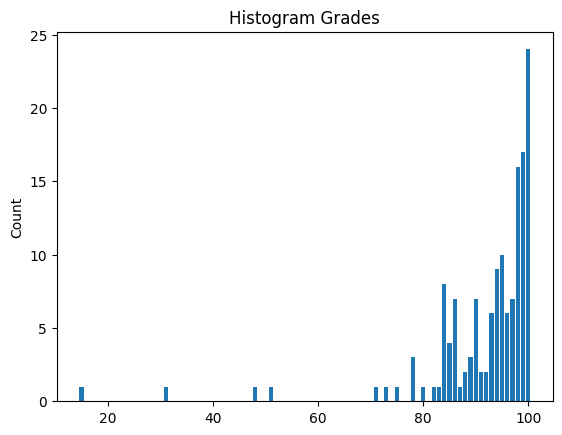

In [181]:
# Let's check grades distribution

plt.title('Histogram Grades')
plt.hist(scores["grade"], rwidth=.8, bins=np.arange(min(scores["grade"]), max(scores["grade"])+2) - 0.5)
plt.ylabel('Count')
plt.show()

In [183]:
df.reset_index(inplace=True, drop=False)
df.rename(columns={"index": "code"}, inplace=True)
df.head()

,code,code,#user_prompts,total_discomfort_count,total_comfort_count,prompt_avg_chars,response_avg_chars
0,0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,8.0,0.0,2.205748,113.703886
1,1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.304163,56.984332
2,2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,8.0,1.0,0.262324,15.134762
3,3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,3.0,0.0,0.123346,27.642008
4,4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,16.0,1.0,0.017986,18.850555


In [52]:
df = pd.merge(df, question_mapping_scores, on="code", how="left")
df.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,2.205748,212.206370,0.153541,0.294879,0.522169,0.352243,0.460606,0.553876,0.167250,0.182938,0.195440
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.304163,113.633582,0.192013,0.795607,0.772184,0.882656,0.607114,0.987511,0.892586,0.570741,0.543866
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,0.262324,17.187601,0.258306,0.295923,0.624824,0.351872,0.643038,0.454314,0.540269,0.546506,0.325793
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.123346,107.092566,0.145965,0.117841,0.267346,0.316809,0.333889,0.309084,0.192434,0.261892,0.407106
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,0.017986,18.850913,0.344182,0.575528,0.782883,0.624833,0.724872,0.872171,0.684797,0.945305,0.511769


#### Merging scores with features

In [53]:
temp_df = pd.merge(df, scores, on='code', how="left")
temp_df.dropna(inplace=True)
temp_df.drop_duplicates("code",inplace=True, keep="first")
temp_df.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8,grade
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,2.205748,212.206370,0.153541,0.294879,0.522169,0.352243,0.460606,0.553876,0.167250,0.182938,0.195440,48.0
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.304163,113.633582,0.192013,0.795607,0.772184,0.882656,0.607114,0.987511,0.892586,0.570741,0.543866,99.0
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,0.262324,17.187601,0.258306,0.295923,0.624824,0.351872,0.643038,0.454314,0.540269,0.546506,0.325793,90.0
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.123346,107.092566,0.145965,0.117841,0.267346,0.316809,0.333889,0.309084,0.192434,0.261892,0.407106,97.0
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,0.017986,18.850913,0.344182,0.575528,0.782883,0.624833,0.724872,0.872171,0.684797,0.945305,0.511769,100.0


In [54]:
X = temp_df[temp_df.columns[1:-1]].to_numpy()
y = temp_df["grade"].to_numpy()
print(X.shape, y.shape)

(122, 17) (122,)


#### Train/Test split

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train set size:", len(X_train))
print("Test set size:", len(X_test))

Train set size: 97
Test set size: 25


#### Fitting a model

#### Predicting and Analyzing 

In [56]:
regressor = DecisionTreeRegressor(random_state=0,criterion='squared_error', max_depth=10)
regressor.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=10, random_state=0)

In [57]:
extracted_MSEs = regressor.tree_.impurity   
for idx, MSE in enumerate(regressor.tree_.impurity):
    print("Node {} has MSE {}".format(idx,MSE))

Node 0 has MSE 163.42034222552866
Node 1 has MSE 126.39409722222263
Node 2 has MSE 64.35004526935154
Node 3 has MSE 167.02777777777737
Node 4 has MSE 83.96484375
Node 5 has MSE 51.6875
Node 6 has MSE 0.0
Node 7 has MSE 10.489795918369055
Node 8 has MSE 0.6666666666660603
Node 9 has MSE 0.0
Node 10 has MSE 0.25
Node 11 has MSE 0.0
Node 12 has MSE 0.0
Node 13 has MSE 0.0
Node 14 has MSE 54.359375
Node 15 has MSE 1.0
Node 16 has MSE 0.0
Node 17 has MSE 0.0
Node 18 has MSE 26.58333333333303
Node 19 has MSE 12.6875
Node 20 has MSE 4.66666666666697
Node 21 has MSE 0.25
Node 22 has MSE 0.0
Node 23 has MSE 0.0
Node 24 has MSE 0.0
Node 25 has MSE 0.0
Node 26 has MSE 9.0
Node 27 has MSE 0.0
Node 28 has MSE 0.0
Node 29 has MSE 100.0
Node 30 has MSE 0.0
Node 31 has MSE 0.0
Node 32 has MSE 27.533240997230678
Node 33 has MSE 25.170927684439448
Node 34 has MSE 22.85062487601499
Node 35 has MSE 6.888888888887777
Node 36 has MSE 0.25
Node 37 has MSE 0.0
Node 38 has MSE 0.0
Node 39 has MSE 0.0
Node 40 h

In [58]:
# Plotting the Tree 
dot_data = tree.export_graphviz(regressor, out_file=None, feature_names=temp_df.columns[1:-1])
graph = graphviz.Source(dot_data)
graph.render("hw")

'hw.pdf'

In [59]:
# Prediction
y_train_pred = regressor.predict(X_train)
y_test_pred = regressor.predict(X_test)

# Calculation of Mean Squared Error (MSE)
print("MSE Train:", mean_squared_error(y_train,y_train_pred))
print("MSE TEST:", mean_squared_error(y_test,y_test_pred))

print("R2 Train:", r2_score(y_train,y_train_pred))
print("R2 TEST:", r2_score(y_test,y_test_pred))


MSE Train: 8.279086892488953
MSE TEST: 101.55122448979591
R2 Train: 0.9493387005574656
R2 TEST: 0.09543774326422416
